In [168]:
# Make sure that the necessary packages are installed
import sys
# !{sys.executable} -m pip -q install --upgrade pip
# !{sys.executable} -m pip -q install numpy matplotlib

In [169]:
# Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm, colors

from scipy.ndimage.filters import uniform_filter1d

# Numerical and array operations
import numpy as np

# Format the output
from IPython.display import display, Markdown, Latex

In [243]:
# Read the polarization data
horizontal_polarization = np.loadtxt('Raw Data/Phase Measurement/Phase_Patch_RIGHT_FrequencySweep.txt')
vertical_polarization = np.loadtxt('Raw Data/Phase Measurement/Phase_Patch_UP_FrequencySweep.txt')

# Read the S21 data
horizontal_slice = np.loadtxt('Raw Data/Gain Measurement/S21_horn-patch_RIGHT.txt')
vertical_slice = np.loadtxt('Raw Data/Gain Measurement/S21_horn-patch_UP.txt')

# Save to variables
v_phase = np.asarray([phase[1] for phase in vertical_polarization])
h_phase = np.asarray([phase[1] for phase in horizontal_polarization])
frequency = np.asarray([f[0] for f in vertical_polarization]) # Frequenct range is the same in both files

v_slice_dB = np.asarray([s21[1] for s21 in vertical_slice])
h_slice_dB = np.asarray([s21[1] for s21 in horizontal_slice])
frequency_gn = np.asarray([f[0] for f in vertical_slice])

## Phase difference calculation and plotting

In [245]:
# Calculate the phase difference and compensate for the negative values
phase_dif = np.subtract(h_phase, v_phase)
phase_dif = np.where(phase_dif < 0, 360 + phase_dif, phase_dif)

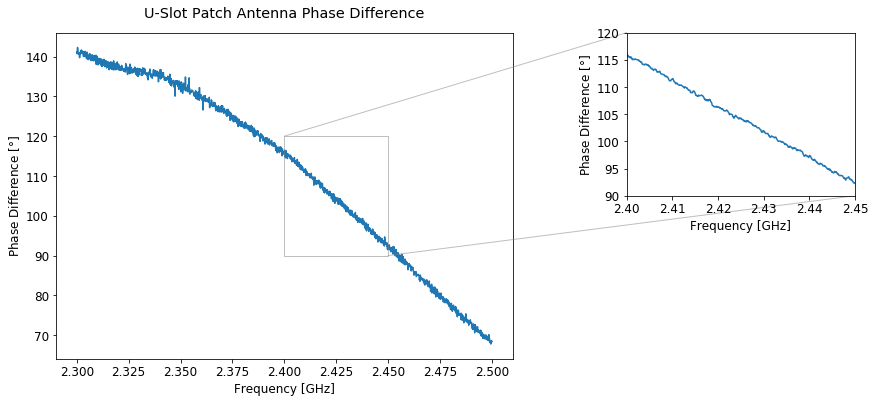

In [246]:
# Create the figure and the space
fig = plt.figure(figsize=(18, 6))
#fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
#ax_2 = fig.add_subplot(1, 2, 2)

# Plot the pattern
plot = ax.plot(frequency, phase_dif)

# In-set axis
zoom = ax.inset_axes([1.25, 0.5, 0.5, 0.5])
#smth = uniform_filter1d(np.subtract(v_phase, h_phase), size=5)
smth = uniform_filter1d(phase_dif, size=5)
zoom.plot(frequency, smth)

zoom.set_xlim(2.40, 2.45)
zoom.set_ylim(90, 120)
zoom.set_xlabel('Frequency [GHz]')
zoom.set_ylabel('Phase Difference [$\degree$]')

ax.indicate_inset_zoom(zoom)

# Change the axis lebels and the title
ax.set_title('U-Slot Patch Antenna Phase Difference', pad=15)
ax.set_xlabel('Frequency [GHz]')
ax.set_ylabel('Phase Difference [$\degree$]')

# Draw the surface
#plt.savefig('patch_phase_difference.pdf', bbox_inches='tight')
plt.show()

## Axial Ratio calculation _(Frequency)_

Source used for the following calculations can be found [here](https://spie.org/publications/fg05_p07-09_polarization_ellipse?SSO=1)

In [247]:
# Phase interpolation. Needed because there are more points in the phase measurement
freq_low = np.where(frequency_gn == 2.3)[0][0]
freq_high = np.where(frequency_gn == 2.5)[0][0] + 1
ph_interp = np.interp(frequency_gn[freq_low:freq_high], frequency, phase_dif)
frequency = frequency_gn[freq_low:freq_high]

In [244]:
frequency

array([2.3     , 2.300125, 2.30025 , ..., 2.49975 , 2.499875, 2.5     ])

In [248]:
# Convert the S21 values to field values
v_slice_lin = np.power(10.0, v_slice_dB/20.0)
h_slice_lin = np.power(10.0, h_slice_dB/20.0)

ph_df_rad = np.deg2rad(ph_interp) # Convert phase difference to radians
a = np.arctan2(v_slice_lin[freq_low:freq_high], h_slice_lin[freq_low:freq_high])
tan_2y = np.tan(2.*a)*np.cos(ph_df_rad)
sin_2x = np.sin(2.*a)*np.sin(ph_df_rad)

x_ellipse = np.arcsin(sin_2x)/2.
axial_ratio = 1./np.tan(x_ellipse)

# Save the data in text for further analysis
np.savetxt('Data Analysis Results/patch_polarization_parameters.txt', np.vstack((frequency, tan_2y, sin_2x)).transpose(), 
           delimiter = '\t', header = 'Frq [GHz]\t tan(2y)\t sin(2x)', fmt = '%.6f')

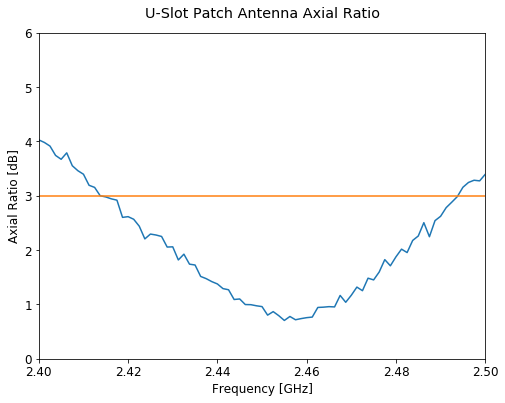

In [249]:
# Create the figure and the space
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

# Plot the pattern
plot = ax.plot(frequency, 20*np.log10(axial_ratio))
ax.plot(frequency, np.ones(len(axial_ratio))*3)

# Change the axis lebels and the title
ax.set_title('U-Slot Patch Antenna Axial Ratio', pad=15)
ax.set_xlabel('Frequency [GHz]')
ax.set_ylabel('Axial Ratio [dB]')
ax.set_xlim(2.4, 2.5)
ax.set_ylim(0, 6)

# Draw the surface
#plt.savefig('patch_axial_ratio_freq.pdf', bbox_inches='tight')
plt.show()

## Axial Ratio calculation (Angle)

In [250]:
v_pol_ang = np.loadtxt('Raw Data/Phase Measurement/Phase_Patch_UP_Scan.txt')
h_pol_ang = np.loadtxt('Raw Data/Phase Measurement/Phase_Patch_RIGHT_Scan.txt')

h_slice_ang = np.loadtxt('Raw Data/Antenna Pattern/Slot_Side-Horizontal_Slice.txt')
v_slice_ang = np.loadtxt('Raw Data/Antenna Pattern/Slot_Up-Vertical_Slice.txt')

angle_rage = np.asarray([phase[0] for phase in h_pol_ang])
v_pol_ang = np.asarray([phase[1] for phase in v_pol_ang])
h_pol_ang = np.asarray([phase[1] for phase in h_pol_ang])

h_slice_ang = np.asarray([phase[1] for phase in h_slice_ang])
h_slice_ang = np.interp(range(-90, 91), range(-90, 91, 2), h_slice_ang)

v_slice_ang = np.asarray([phase[1] for phase in v_slice_ang])

phase_dif_ang = np.subtract(h_pol_ang, v_pol_ang)
phase_dif_ang = np.where(phase_dif_ang < 0, 360 + phase_dif_ang, phase_dif_ang)

In [251]:
# Convert the S21 values to field values
h_slice_ang_lin = np.power(10.0, h_slice_ang/20.0)
v_slice_ang_lin = np.power(10.0, v_slice_ang/20.0)

phase_dif_ang_rad = np.deg2rad(phase_dif_ang) # Convert phase difference to radians
a_ang = np.arctan2(v_slice_ang_lin, h_slice_ang_lin)
tan_2y_ang = np.tan(2.*a_ang)*np.cos(phase_dif_ang_rad)
sin_2x_ang = np.sin(2.*a_ang)*np.sin(phase_dif_ang_rad)

x_ellipse_ang = np.arcsin(sin_2x_ang)/2.
axial_ratio_ang = 1./np.tan(x_ellipse_ang)

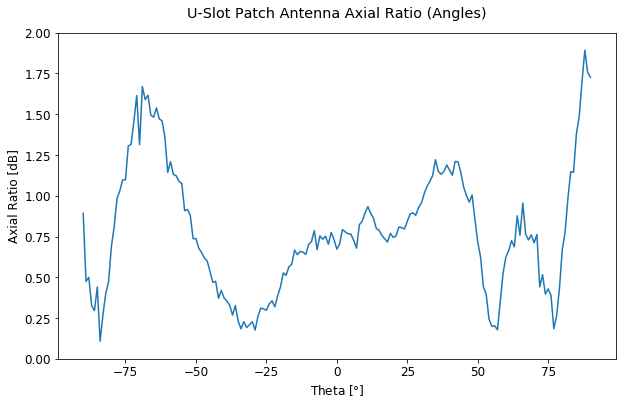

In [252]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

# Plot the pattern
plot = ax.plot(angle_rage, 20.*np.log10(axial_ratio_ang))

ax.set_title('U-Slot Patch Antenna Axial Ratio (Angles)', pad=15)
ax.set_xlabel('Theta [$\degree$]')
ax.set_ylabel('Axial Ratio [dB]')
ax.set_ylim(0, 2)

# Draw the surface
#plt.savefig('patch_axial_ratio_angle.pdf', bbox_inches='tight')
plt.show()

## Polarization loss calculation

Using the two defining angles for the polarization, `y` and `x` on the Poinacre sphere, we can find the polarization missmatch of the two antennas and the consequent loss from it. The source is the book by _John D. Kraus_ `Antennas for all applications, 3rd edition`. 

In [253]:
# Receiving antenna
rcv_2y = np.deg2rad(0)
rcv_2x = np.deg2rad(90)

# Patch antenna Poincare sphere positions
patch_2y = np.arctan(tan_2y)
patch_2x = np.arcsin(sin_2x)
patch_2y_ang = np.arctan(tan_2y_ang)
patch_2x_ang = np.arcsin(sin_2x_ang)

# Great circle distance on the Poincare sphere
#dist = np.arccos(np.cos(rcv_2x)*np.cos(rcv_2y)) + np.arccos(np.cos(patch_2x)*np.cos(patch_2y))
dist = np.arccos(np.sin(patch_2x)*np.sin(rcv_2x) + np.cos(patch_2x)*np.cos(rcv_2x)*np.cos(rcv_2y - patch_2y))
dist_ang = np.arccos(np.sin(patch_2x_ang)*np.sin(rcv_2x) + np.cos(patch_2x_ang)*np.cos(rcv_2x)*np.cos(rcv_2y - patch_2y_ang))

# Polarization loss
pol_loss = np.power(np.cos(dist/2.), 2.)
pol_loss_ang = np.power(np.cos(dist_ang/2.), 2.)

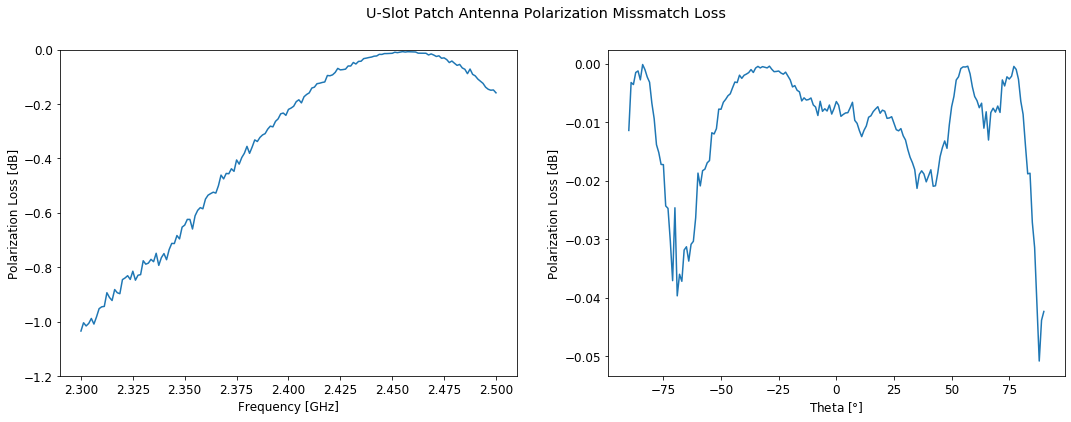

In [254]:
fig = plt.figure(figsize=(18, 6))
plt.rcParams.update({'font.size': 12})
fig.suptitle('U-Slot Patch Antenna Polarization Missmatch Loss')

ax_1 = fig.add_subplot(1, 2, 1)
ax_2 = fig.add_subplot(1, 2, 2)

ax_1.plot(frequency, 10*np.log10(pol_loss))
#ax_1.set_title('U-Slot Patch Antenna polarization Missmatch Loss (Frequency)', pad=15)
ax_1.set_xlabel('Frequency [GHz]')
ax_1.set_ylabel('Polarization Loss [dB]')
ax_1.set_ylim(-1.2, 0)

ax_2.plot(angle_rage, 10*np.log10(pol_loss_ang))
#ax_2.set_title('U-Slot Patch Antenna polarization Missmatch Loss (Angle)', pad=15)
ax_2.set_xlabel('Theta [$\degree$]')
ax_2.set_ylabel('Polarization Loss [dB]')

# Draw the surface
#plt.savefig('patch_polarization_loss.pdf', bbox_inches='tight')
plt.show()

# Save the data in text for further analysis
np.savetxt('Data Analysis Results/patch_polarization_loss.txt', np.vstack((frequency, 10*np.log10(pol_loss))).transpose(), 
           delimiter = '\t', header = 'Frq [GHz]\t Loss [dB]', fmt = '%.6f')